## Libraries

In [1]:
import numpy as np
#from scipy.signal import lfilter, firwin
from pylab import *
from scipy.fftpack import fft,fftshift
#import scipy.signal as signal
from tool._fixedInt import *
import scipy.signal


## Create a signal for demonstration

320 samples of (1500Hz + 17000 Hz) at 48 kHz


In [2]:

sample_rate = 48000.
nsamples = 320

F_1K5Hz = 1500.
A_1K5Hz = 1.0
 
F_17KHz = 17000.
A_17KHz = 0.5
 
t = np.arange(nsamples) / sample_rate

noise  = A_17KHz * np.sin(2*np.pi*F_17KHz*t)
signal = A_1K5Hz  * np.sin(2*np.pi*F_1K5Hz*t)
signal_gen = signal + noise
 

# FFT
NFFT = 1024
fs = sample_rate

fft_signal     = fft(signal,NFFT)
fft_signal_gen = fft(signal_gen,NFFT)
xfft           = np.linspace(0.0, 1.0/(2.0*t[1]), NFFT//2)

## Plot signals

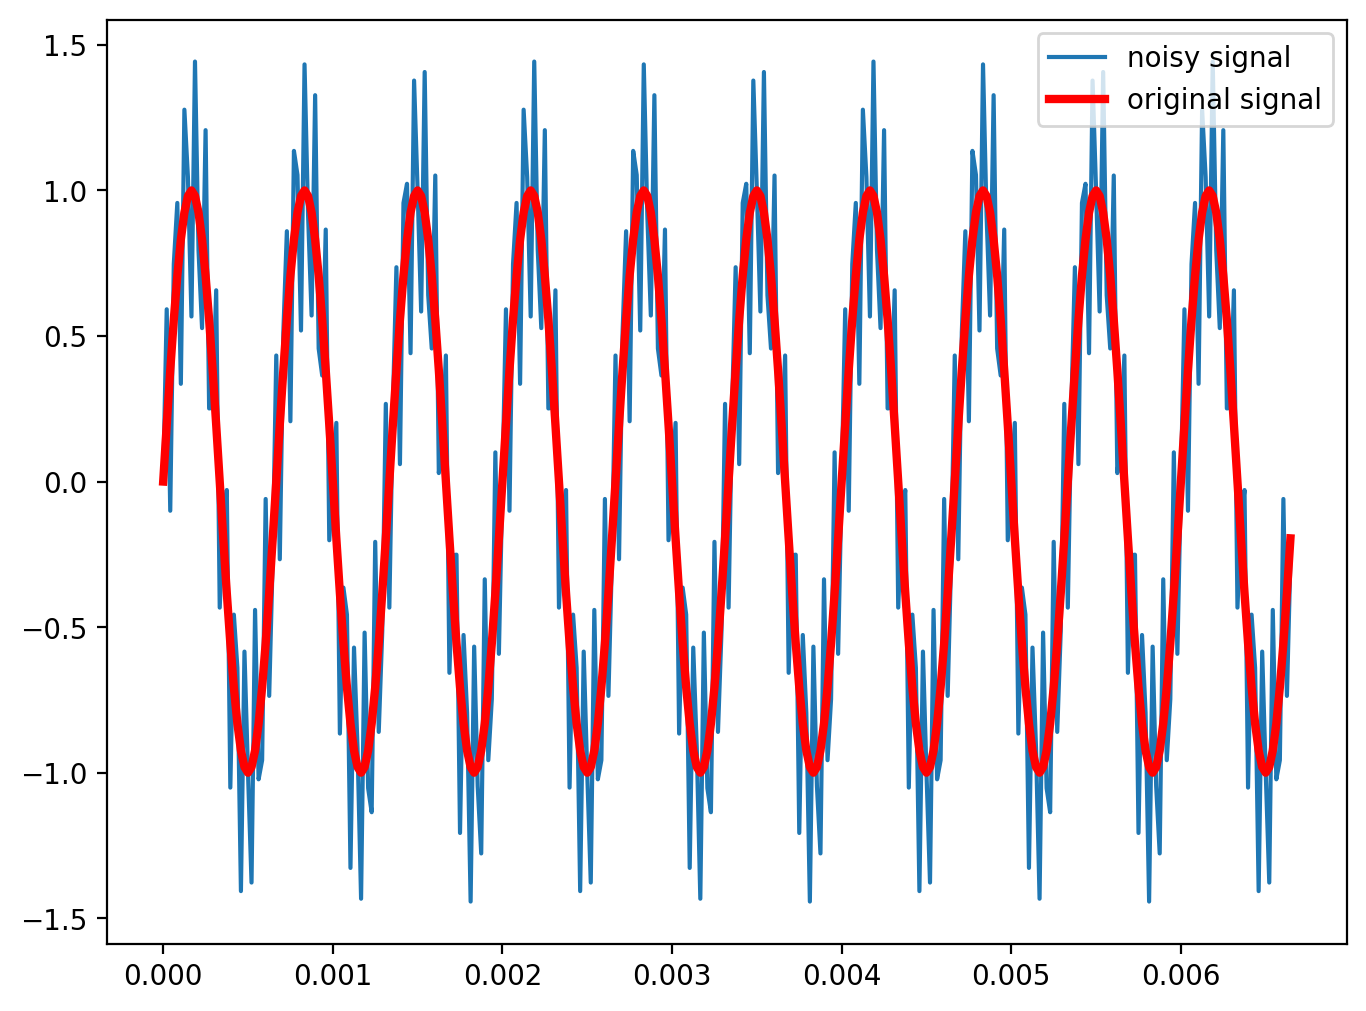

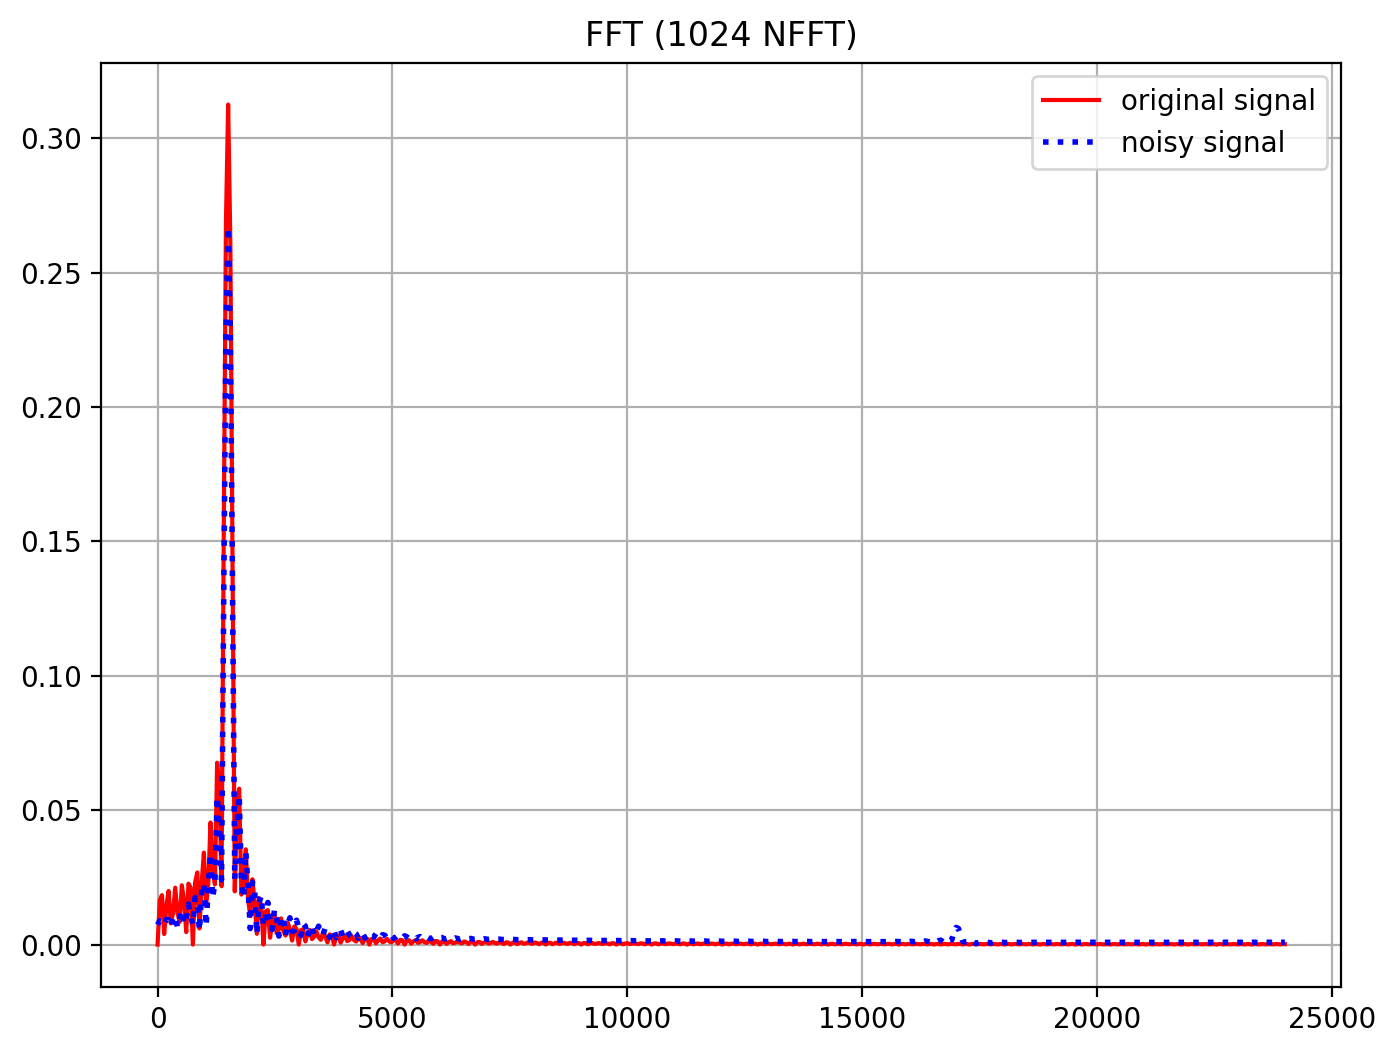

In [14]:

figure(1, figsize=(8, 6), dpi=200)
# Plot the noisy signal and original signal
plot(t, signal_gen, label='noisy signal')
plot(t, signal, 'r-', linewidth=3, label='original signal') 
legend()


# FFT PLOT
figure(2, figsize=(8, 6), dpi=200)
title('FFT (%d NFFT)' % NFFT)
plot(xfft,2.0/NFFT * np.abs(fft_signal[0:NFFT//2]),'r-', label='original signal')
plot(xfft,2.0/NFFT * np.abs(fft_signal_gen[0:NFFT//2]),'b:' ,linewidth=2, label='noisy signal')
legend()
grid(True)


## Create a FIR filter and apply it to signal

In [15]:

# The Nyquist rate of the signal.
nyq_rate = sample_rate / 2.
 
# The cutoff frequency of the filter: 8KHz
cutoff_hz = 8000.0
 
# Length of the filter (number of coefficients, i.e. the filter order + 1)
numtaps = 15
 
# Use firwin to create a lowpass FIR filter
fir_coeff = scipy.signal.firwin(numtaps, cutoff_hz/nyq_rate)

# Use lfilter to filter the signal with the FIR filter
filtered_signal = scipy.signal.lfilter(fir_coeff, 1.0, signal_gen)

# FFT
fft_filtered_signal = fft(filtered_signal,NFFT)


## Plot the FIR filter coefficients

(-0.15677283652191254,
 3.292229566960163,
 -95.26927888124239,
 4.536632327678211)

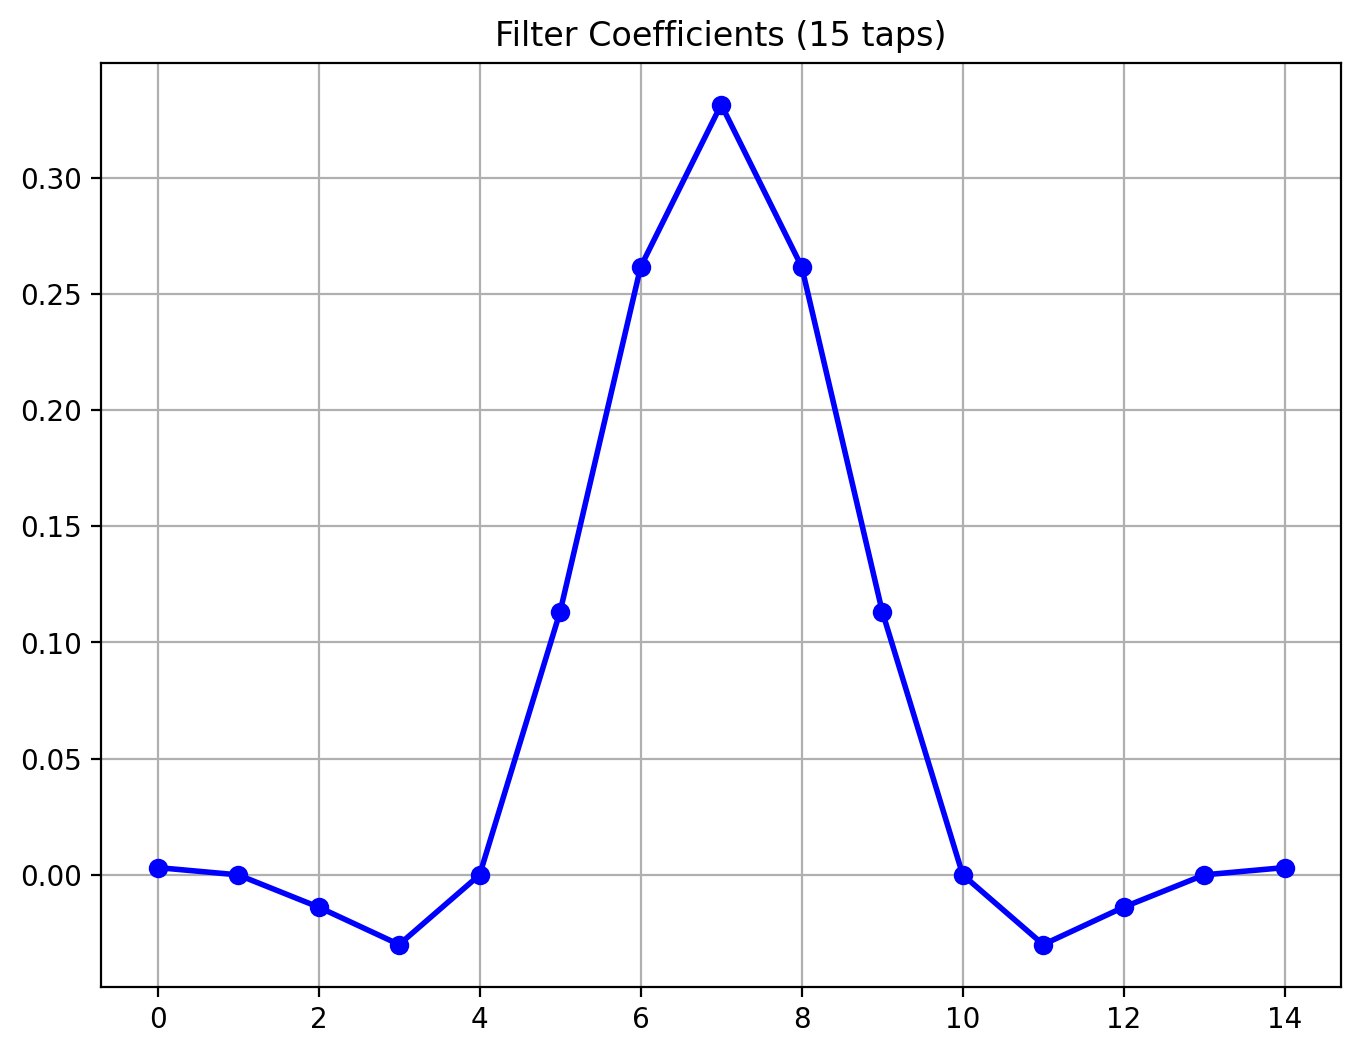

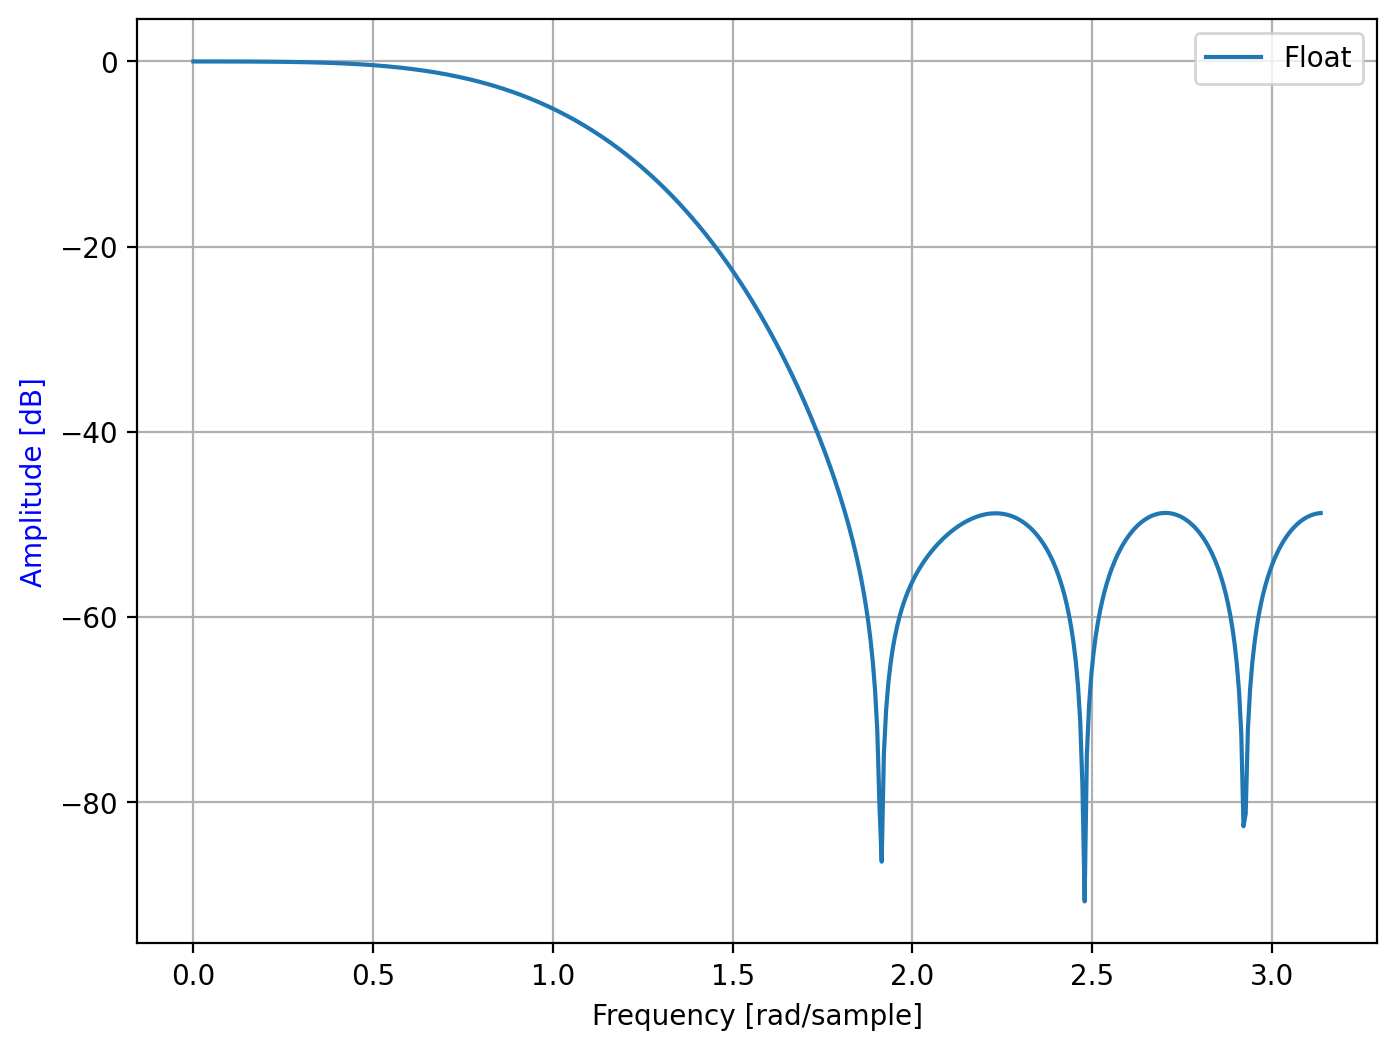

In [16]:

figure(3,figsize=(8, 6), dpi=200)
plot(fir_coeff, 'bo-', linewidth=2)
title('Filter Coefficients (%d taps)' % numtaps)
grid(True)

figure(4,figsize=(8, 6), dpi=200)
w,h = scipy.signal.freqz(fir_coeff)
plt.plot(w, 20 * np.log10(abs(h)),label='Float')
plt.legend()
plt.ylabel('Amplitude [dB]', color='b')
plt.xlabel('Frequency [rad/sample]')
plt.grid()
plt.axis('tight')

## Plot the original and filtered signals.

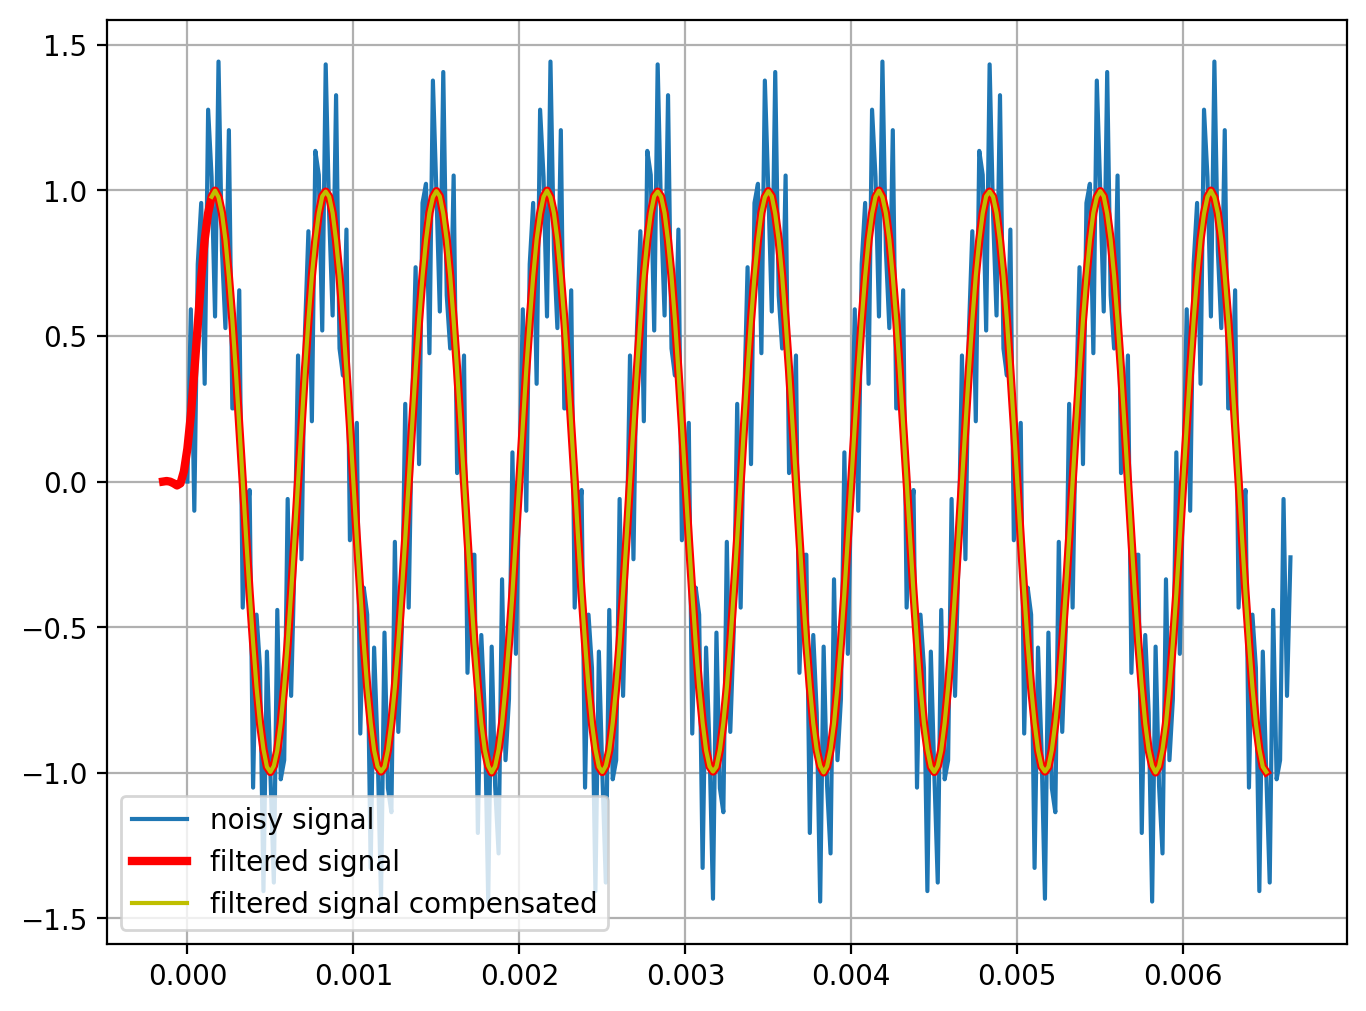

In [6]:
# The first N-1 samples are "corrupted" by the initial conditions
warmup = numtaps - 1
 
# The phase delay of the filtered signal
delay = (warmup / 2) / sample_rate
# Plot just the "good" part of the filtered signal.  The first N-1
# samples are "corrupted" by the initial conditions.
figure(5,figsize=(8, 6), dpi=200)
plot(t, signal_gen, label='noisy signal') # Plot the original signal
plot(t-delay, filtered_signal, 'r-', linewidth=3 , label='filtered signal') # Plot the filtered signal, shifted to compensate for the phase delay
plot(t[warmup:]-delay, filtered_signal[warmup:], 'y', label='filtered signal compensated')
legend()
grid(True)
show()

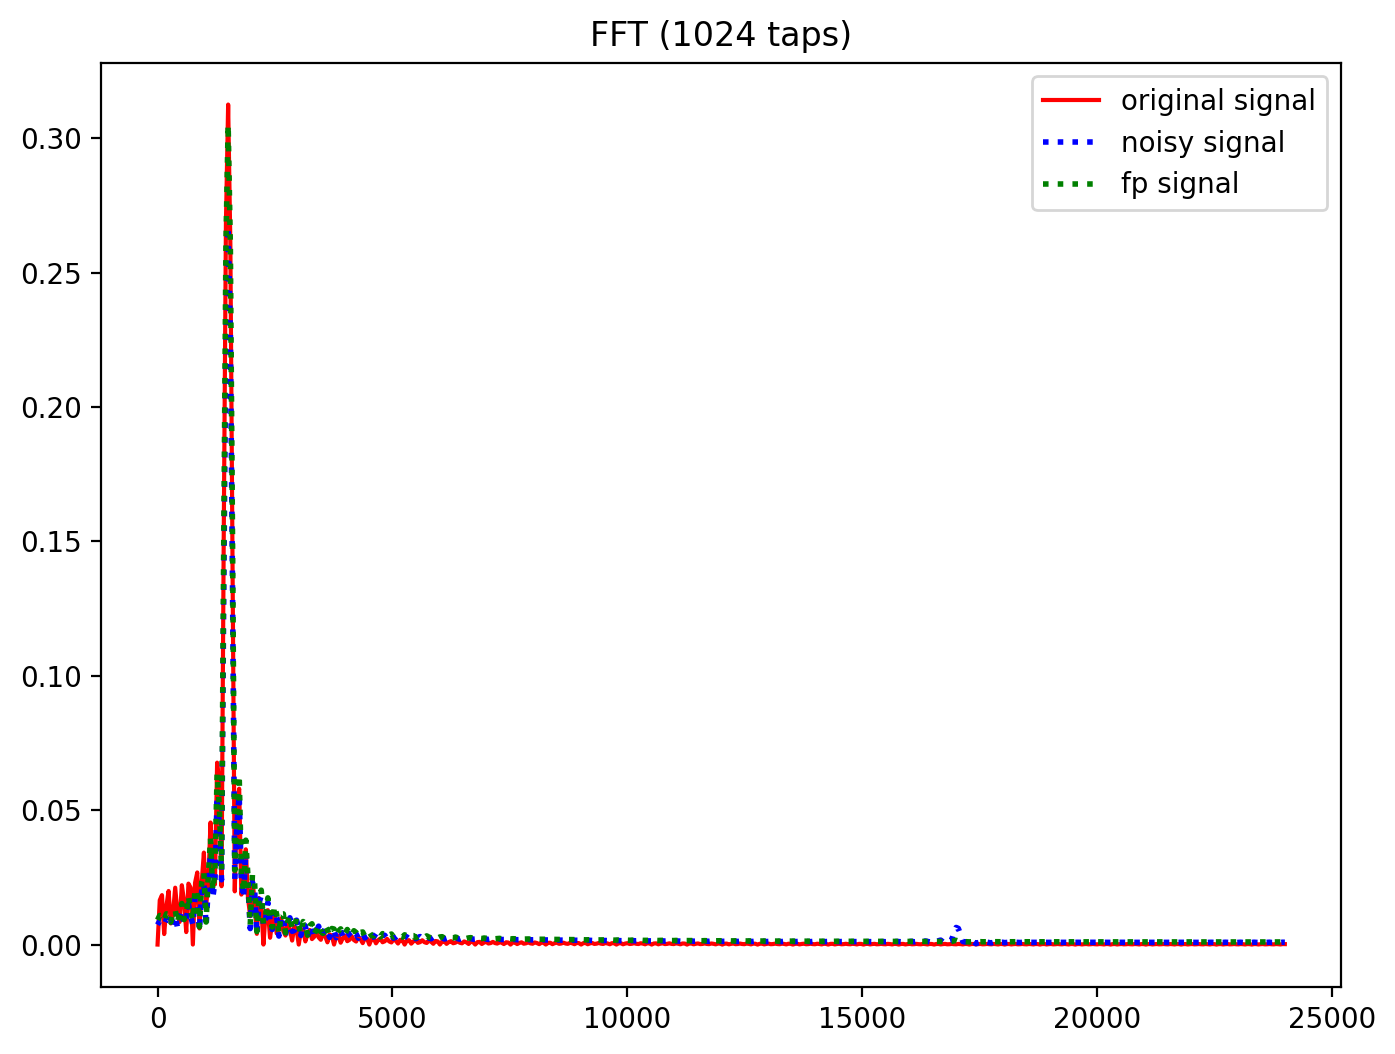

In [17]:
# FFT PLOT
#figure(2, figsize=(8, 6), dpi=200)
figure(6,figsize=(8, 6), dpi=200)
title('FFT (%d taps)' % NFFT)
plot(xfft,2.0/NFFT * np.abs(fft_signal[0:NFFT//2]),'r-', label='original signal')
plot(xfft,2.0/NFFT * np.abs(fft_signal_gen[0:NFFT//2]),'b:' ,linewidth=2, label='noisy signal')
plot(xfft,2.0/NFFT * np.abs(fft_filtered_signal[0:NFFT//2]),'g:' ,linewidth=2, label='fp signal')
legend()
show()

## Quantization 

In [22]:
def fir_filter(x,c):
    Xn_Coeff = x * c
    fp_acumulador = Xn_Coeff[0]
    for index in range(1,len(Xn_Coeff)):
        fp_acumulador =  fp_acumulador + Xn_Coeff[index]
    return fp_acumulador

taps= len(fir_coeff)
init_coeff = np.ones(taps)

coeff = arrayFixedInt(9,8,fir_coeff)
xn    =  arrayFixedInt(15,13,init_coeff)

value_coeff = [a.fValue for a in coeff]

fp_filtered = []
temp = [0.0]*taps

for value in signal_gen:
    temp.insert(0,value)
    temp.pop()
    for j in range(taps):
        xn[j].value = temp[j]
    Yn = fir_filter(xn,coeff)
    fp_filtered.append(Yn.fValue)  


## Plot Signal and Filter

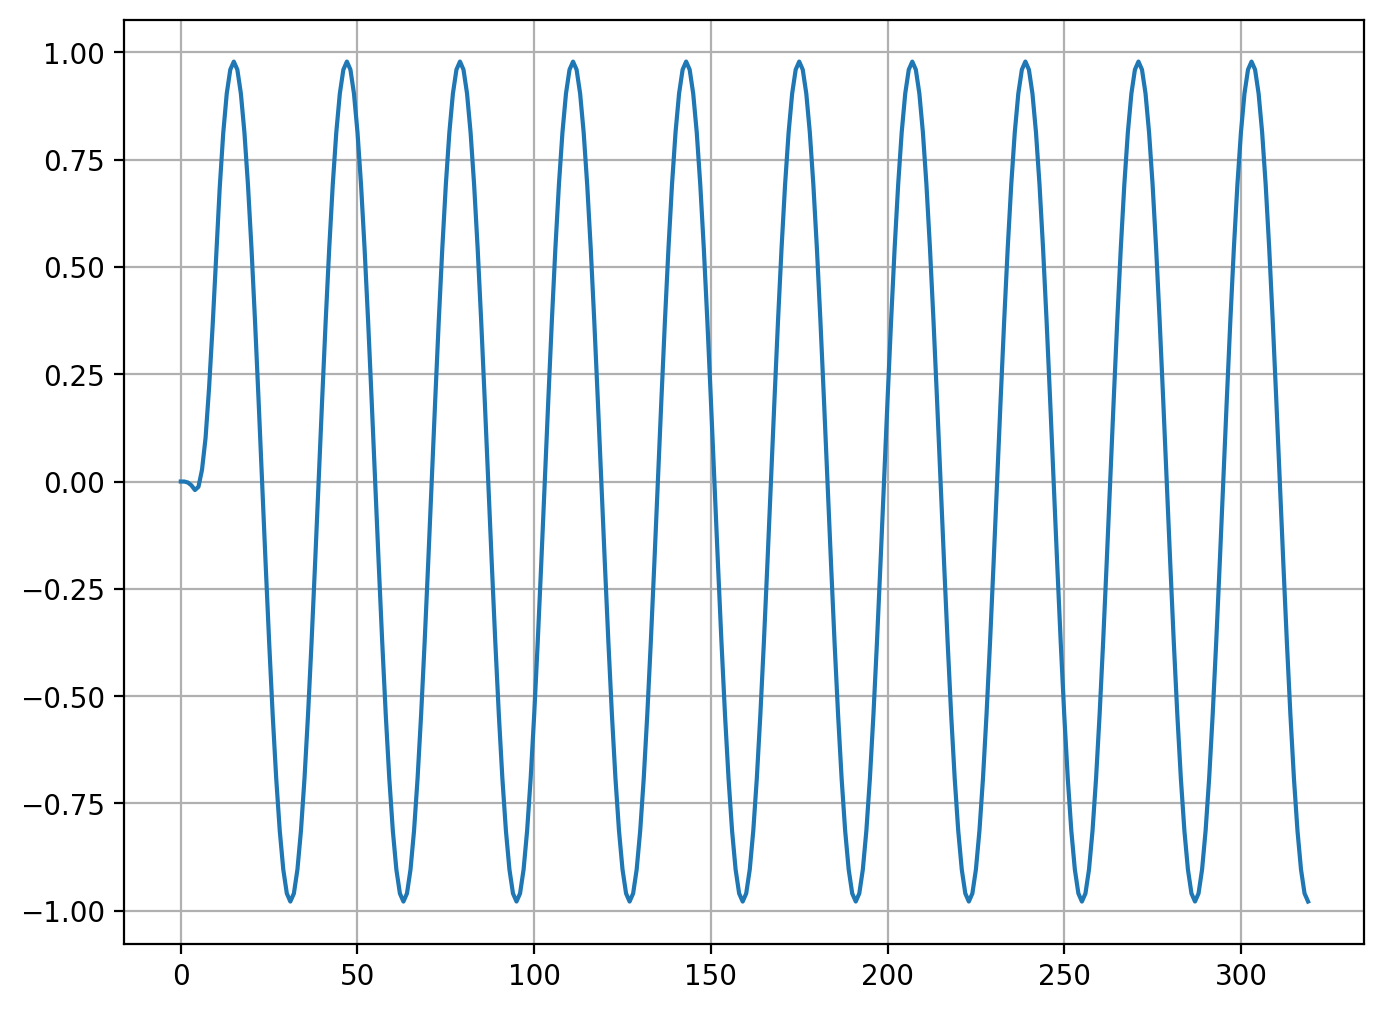

In [23]:
figure(7,figsize=(8, 6), dpi=200)
plot(fp_filtered)
fft_signal_gen = fft(fp_filtered,NFFT)
grid(True)


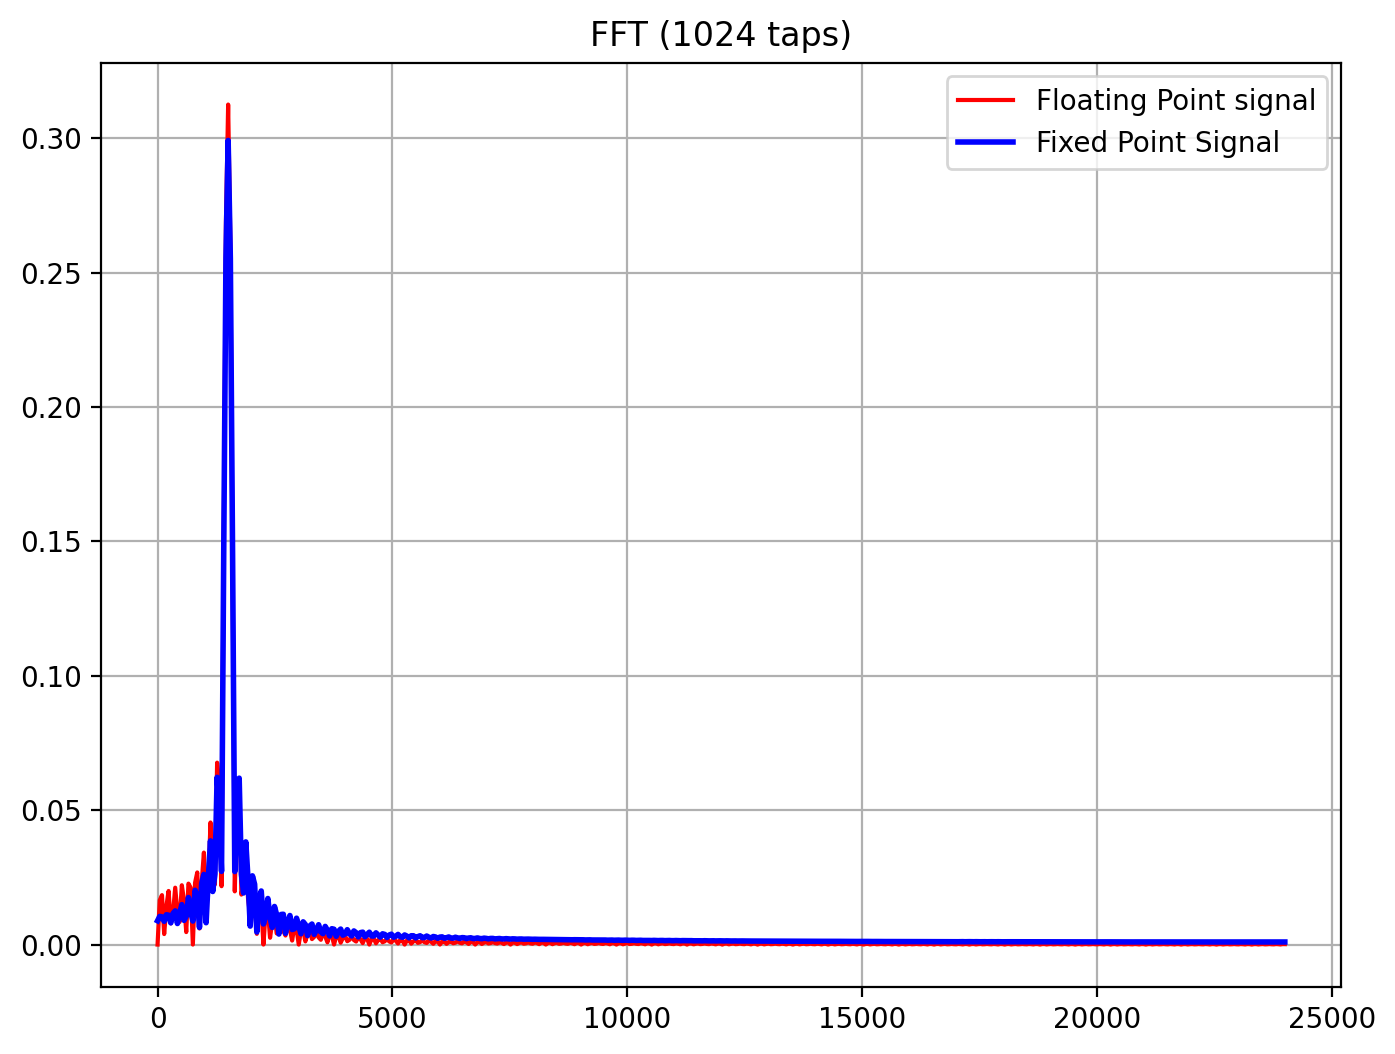

In [24]:
# FFT PLOT
#figure(2, figsize=(8, 6), dpi=200)
figure(8,figsize=(8, 6), dpi=200)
title('FFT (%d taps)' % NFFT)
plot(xfft,2.0/NFFT * np.abs(fft_signal[0:NFFT//2]),'r-', label='Floating Point signal')
plot(xfft,2.0/NFFT * np.abs(fft_signal_gen[0:NFFT//2]),'b' ,linewidth=2, label='Fixed Point Signal')
legend()
grid(True)

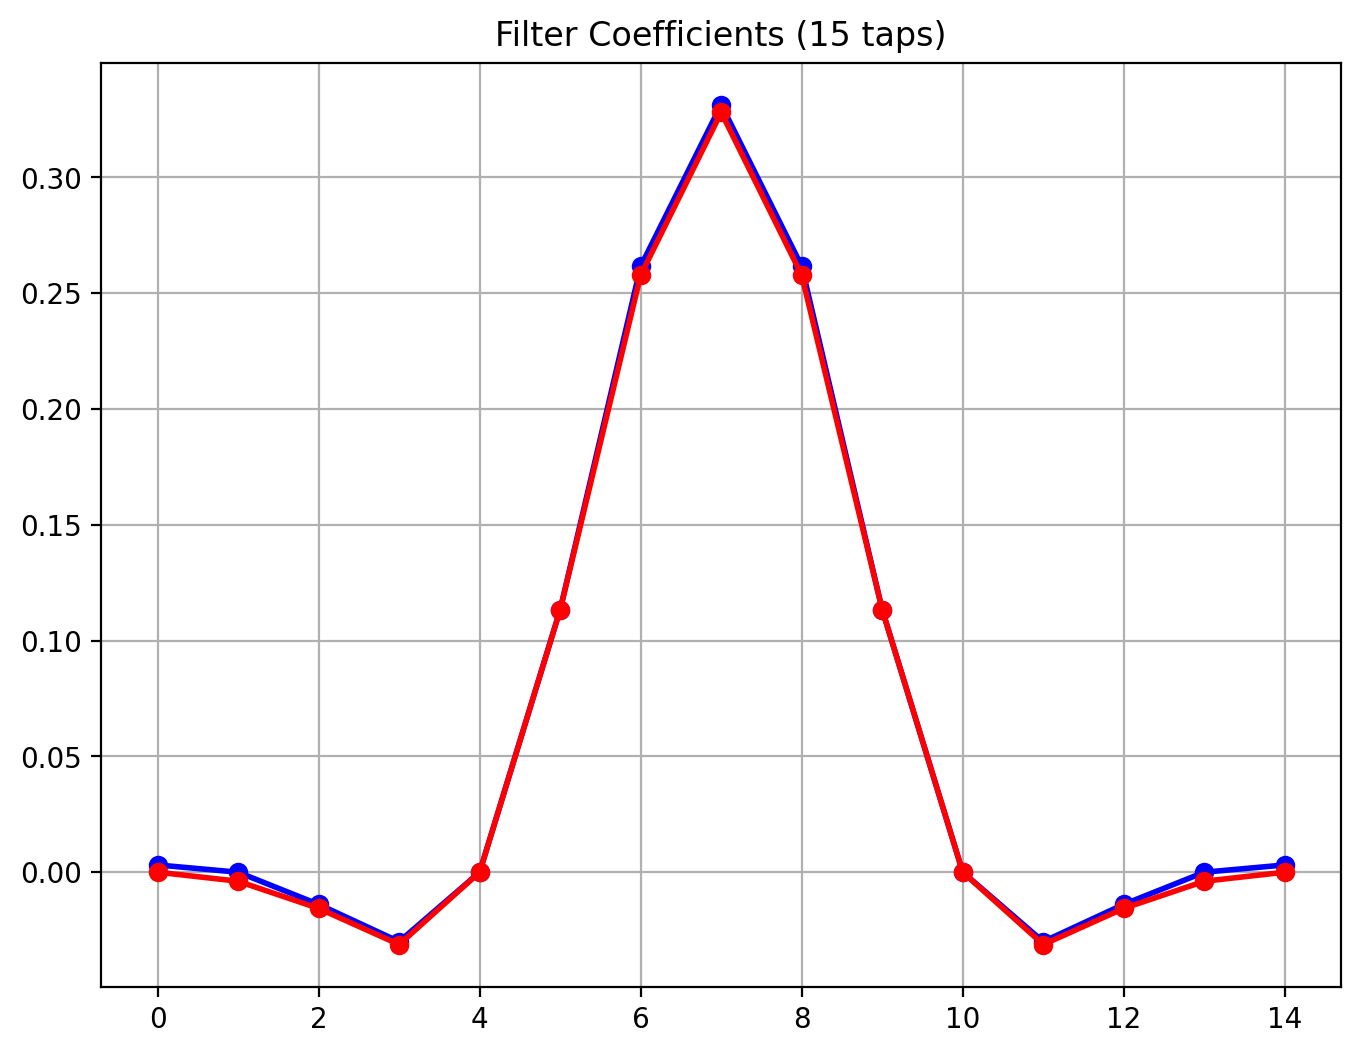

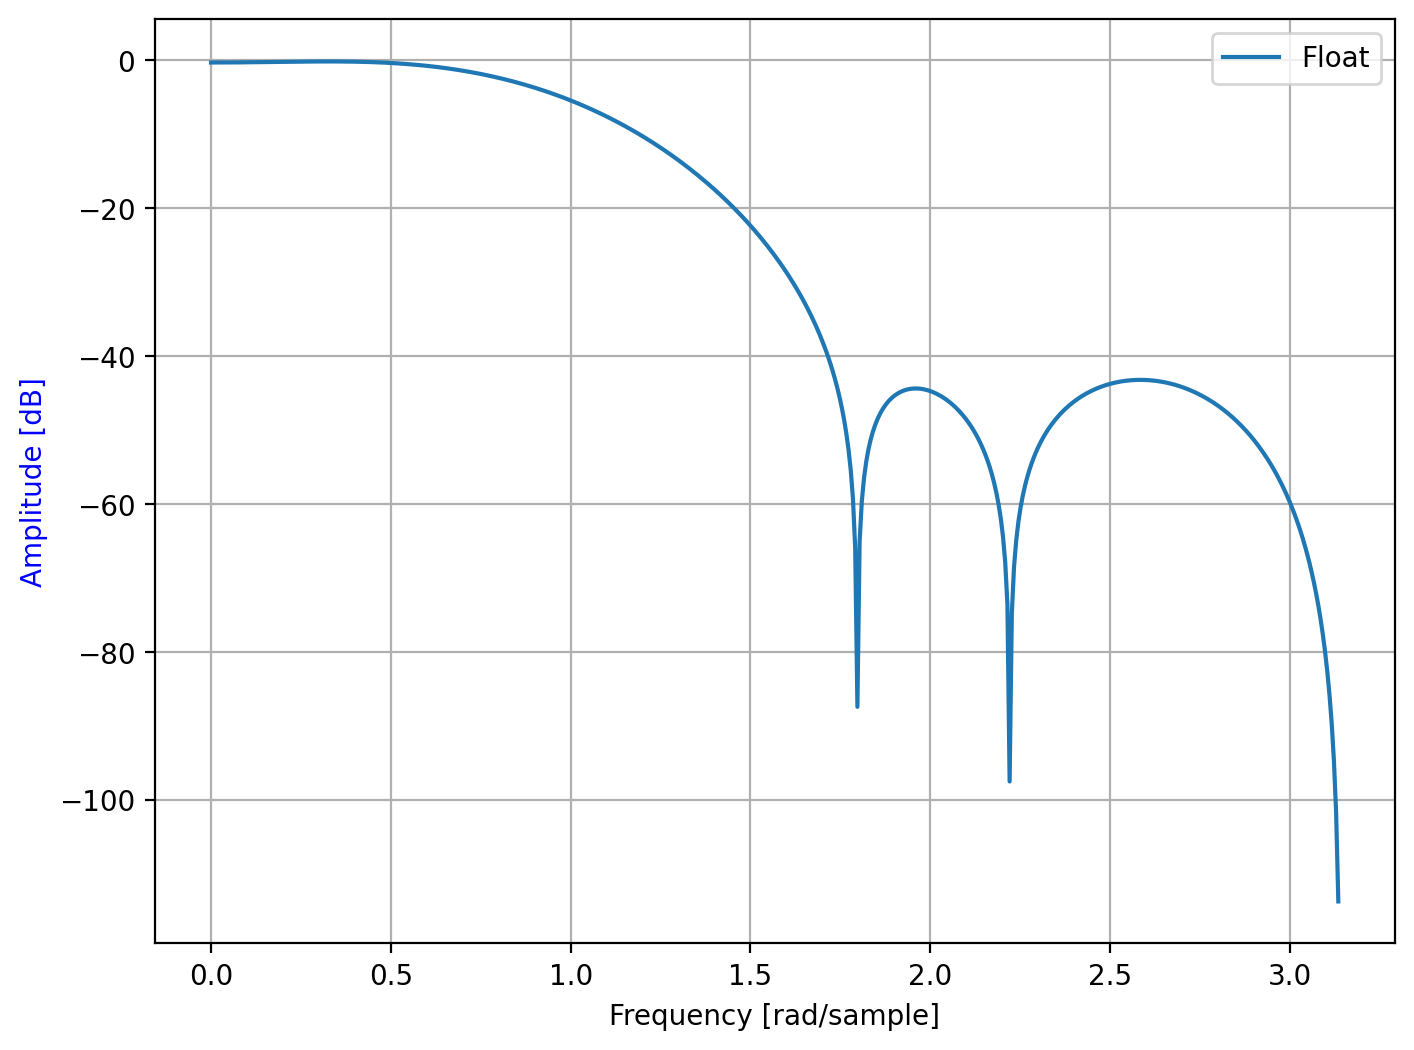

In [25]:
#------------------------------------------------
# Plot the FIR filter coefficients.
#------------------------------------------------
figure(9,figsize=(8, 6), dpi=200)
plot(fir_coeff, 'bo-', linewidth=2, label='Floating Point FIR Coeff')
plot(value_coeff, 'ro-', linewidth=2, label='Fixed Point FIR Coeff')
title('Filter Coefficients (%d taps)' % numtaps)
grid(True)

figure(10,figsize=(8, 6), dpi=200)
w,h = scipy.signal.freqz(value_coeff)
plt.plot(w, 20 * np.log10(abs(h)),label='Float')
plt.legend()
plt.ylabel('Amplitude [dB]', color='b')
plt.xlabel('Frequency [rad/sample]')
plt.grid()
plt.axis('tight')
show()